In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from pydicom import dcmread
import pydicom
import gc

In [2]:
os.listdir("../input/")

['rsna-pneumonia-detection-challenge']

Reading csv which has coordinates for bounding box. These coordinates encompass the opaque region in chest images which are used to signify Pneumonia. Images with target label 0 has NaN coordinates indicating no opacity and hence, no pneumonia. Since, we are building a segmentation model we do not need to replace/remove the NaNs. For images with target label 1 (Pneumonia) the coordinates are used to create mask which the model tries to predict to localize opacity.

In [3]:
df_target = pd.read_csv("../input/rsna-pneumonia-detection-challenge/stage_2_train_labels.csv")
df_target.head()

,patientId,x,y,width,height,Target
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1


There are 3 classes:
* No lung opacity/Not Normal
* Lung Opacity
* Normal

In [4]:
df_detailed_labels = pd.read_csv("../input/rsna-pneumonia-detection-challenge/stage_2_detailed_class_info.csv")
df_detailed_labels.head()

,patientId,class
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,No Lung Opacity / Not Normal
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,No Lung Opacity / Not Normal
2,00322d4d-1c29-4943-afc9-b6754be640eb,No Lung Opacity / Not Normal
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,Normal
4,00436515-870c-4b36-a041-de91049b9ab4,Lung Opacity


Merged Datadrame that consists of coordinates, target and class.
Upon merging it is oberserved that class "No Lung Opacity/ Not normal" also have a label of 0. This means Pneumonia Images are the ones with only opacity and Target label 1. For rest of the classes the target label is 0

In [5]:
df = df_target.merge(df_detailed_labels, left_on='patientId', right_on='patientId', how='inner')
df.head()

,patientId,x,y,width,height,Target,class
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0,Normal
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1,Lung Opacity


In [6]:
'''Clear some memory by removing redundant dataframes'''
del df_target
del df_detailed_labels
gc.collect()

60

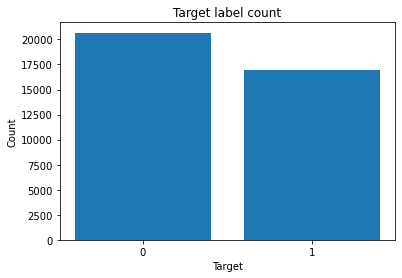

Count for label 0: 20672 (54.93635228148502%)
Count for label 1: 16957 (45.06364771851498%)
Total labels: 37629


In [7]:
'''Count for Target labels'''
labels = df.Target.value_counts()
plt.figure()
plt.bar([0, 1], [labels[0], labels[1]])
plt.xticks([0,1])
plt.title("Target label count")
plt.xlabel("Target")
plt.ylabel("Count")
plt.show()
print("Count for label 0: {} ({}%)\nCount for label 1: {} ({}%)\nTotal labels: {}".format(labels[0], labels[0]*100/len(df), labels[1], labels[1]*100/len(df), len(df)))


Roughly 55% of labels are of Non-Pneumonia and 45% are of Pneumonia. There is class imbalance but it is not significant.

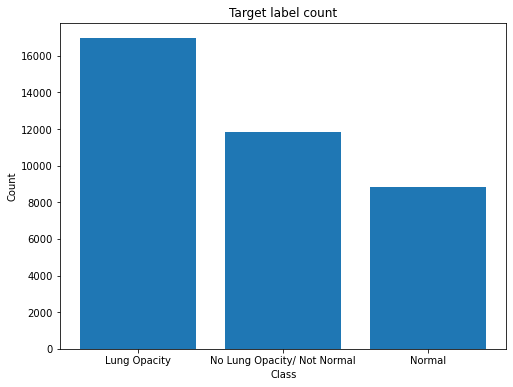

Lung Opacity: 16957 (45.06364771851498%)
No Lung Opacity/ Not Normal: 11821 (31.414600441149112%)
Normal: 8851 (23.52175184033591%)


In [8]:
'''Count for Classes'''
labels = df["class"].value_counts()
plt.figure(figsize=(8,6))
plt.bar(["Lung Opacity", "No Lung Opacity/ Not Normal", "Normal"], [labels[0], labels[1], labels[2]])
plt.xticks([0,1,2])
plt.title("Target label count")
plt.xlabel("Class")
plt.ylabel("Count")
plt.show()
print("Lung Opacity: {} ({}%)".format(labels[0], labels[0]*100/len(df)))
print("No Lung Opacity/ Not Normal: {} ({}%)".format(labels[1], labels[1]*100/len(df)))
print("Normal: {} ({}%)".format(labels[2], labels[2]*100/len(df)))

We can oberserve that class Lung Opacity has same count as Target label 1.

For scope of the project, the aim is to correctly identify Pneumonia and localize it. Hence, if image has opacity then "Pneumonia" else "No Pneumonia".